In [8]:
## for data
import datasets  #(1.13.3)
import pandas as pd  #(0.25.1)
import numpy  #(1.16.4)
## for plotting
import matplotlib.pyplot as plt  #(3.1.2)
import seaborn as sns  #(0.9.0)
## for preprocessing
import re
import nltk  #(3.4.5)
import contractions  #(0.0.18)
## for textrank
import gensim  #(3.8.1)
## for evaluation
import rouge  #(1.0.0)
import difflib
## for seq2seq
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing #(2.6.0)


In [9]:
## load the full dataset of 300k articles
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')
lst_dics = [dic for dic in dataset["train"]]
## keep the first N articles if you want to keep it lite 
dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]].head(20000)
dtf.head()

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [10]:
i = 1
print("--- Full text ---")
print(dtf["text"][i])
print("--- Summary ---")
print(dtf["y"][i])

--- Full text ---
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

In [11]:
dtf_train = dtf.iloc[i+1:]
dtf_test = dtf.iloc[:i+1]

In [13]:
## create stopwords
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")
## add words that are too frequent
lst_stopwords = lst_stopwords + ["cnn","say","said","new"]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
## create stopwords
nltk.download('wordnet')
lst_stopwords = nltk.corpus.stopwords.words("english")
## add words that are too frequent
lst_stopwords = lst_stopwords + ["cnn","say","said","new"]

## cleaning function
def utils_preprocess_text(txt, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt   
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
    ### lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ### remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in 
                   lst_stopwords]
    ### back to string
    txt = " ".join(lst_txt)
    return txt

## apply function to both text and summaries
dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_train["y_clean"] = dtf_train["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))

[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-15-c2cc162be299>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
<ipython-input-15-c2cc162be299>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["y_clean"] = dtf_train["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=Tr

In [30]:
## apply function to both text and summaries
dtf_test["text_clean"] = dtf_test["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_test["y_clean"] = dtf_test["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))

<ipython-input-30-16cd29658146>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_test["text_clean"] = dtf_test["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
<ipython-input-30-16cd29658146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_test["y_clean"] = dtf_test["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-18-8c1025b0b37d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train['word_count_text_clean'] = dtf_train["text_clean"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
<ipython-input-18-8c1025b0b37d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dtf_train["word_coun

<Axes: xlabel='word_count_text_clean', ylabel='Density'>

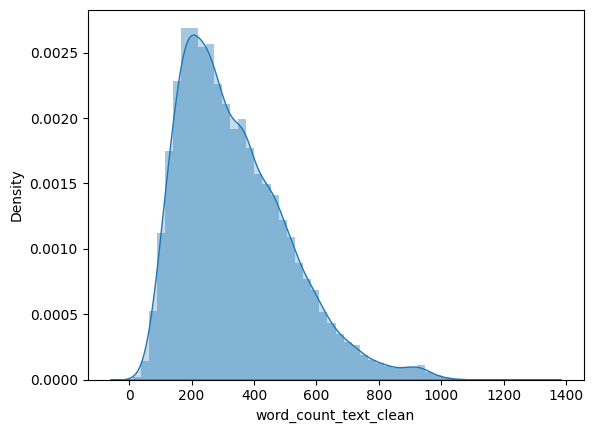

In [18]:
## count
nltk.download('punkt')
dtf_train['word_count_text_clean'] = dtf_train["text_clean"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
## plot
sns.distplot(dtf_train["word_count_text_clean"], hist=True, kde=True, kde_kws={"shade":True})

<ipython-input-19-78bf86a3725b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train['word_count_y_clean'] = dtf_train["y_clean"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
<ipython-input-19-78bf86a3725b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dtf_train["word_count_y_clean"], hist=True, kde=True, kde_kws={"shade":True})
/usr/local/lib/python3.9/dist-packages/seaborn/distribution

<Axes: xlabel='word_count_y_clean', ylabel='Density'>

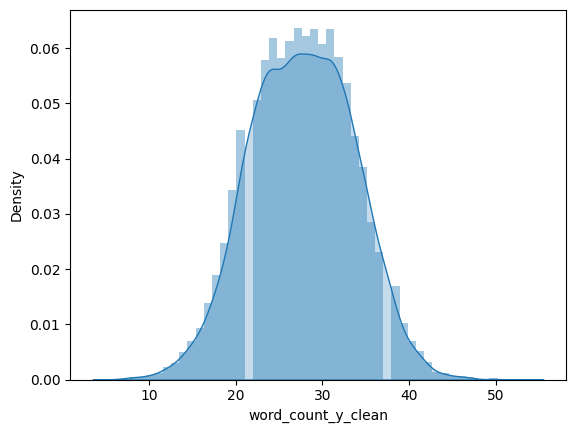

In [19]:
## count
dtf_train['word_count_y_clean'] = dtf_train["y_clean"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
## plot
sns.distplot(dtf_train["word_count_y_clean"], hist=True, kde=True, kde_kws={"shade":True})

In [20]:
X_len = 400
y_len = 40

<ipython-input-21-a91f826ea53a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_freq = dtf_freq.append(dtf_n)
<ipython-input-21-a91f826ea53a>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))


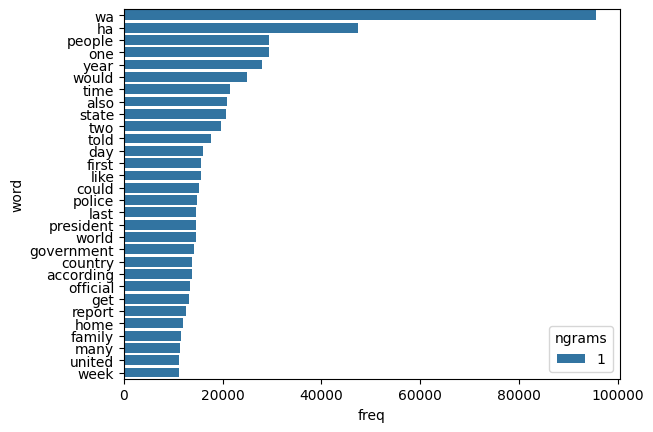

In [21]:
# add y_clean to get for y
lst_tokens = nltk.tokenize.word_tokenize(dtf_train["text_clean"].str.cat(sep=" "))
ngrams = [1]
    
## calculate
dtf_freq = pd.DataFrame()
for n in ngrams:
    
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
    dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                        ["word","freq"])
    dtf_n["ngrams"] = n
    dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq_X= dtf_freq.sort_values(["ngrams","freq"], ascending=
                         [True,False])
    
## plot
sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
 data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

In [22]:
thres = 5 #<-- min frequency
X_top_words = len(dtf_freq_X[dtf_freq_X["freq"]>thres])
# y_top_words = len(dtf_freq_y[dtf_freq_y["freq"]>thres])

In [23]:
lst_corpus = dtf_train["text_clean"]
## tokenize text
tokenizer = kprocessing.text.Tokenizer(num_words=X_top_words, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = {"<PAD>":0}
dic_vocabulary.update(tokenizer.word_index)
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [68]:
lst_corpus1 = dtf_train["y_clean"]
## tokenize text
tokenizer1 = kprocessing.text.Tokenizer(num_words=X_top_words, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer1.fit_on_texts(lst_corpus1)
dic_vocabulary = {"<PAD>":0}
dic_vocabulary.update(tokenizer1.word_index)
## create sequence
lst_text2seq1= tokenizer1.texts_to_sequences(lst_corpus1)
## padding sequence
y_train = kprocessing.sequence.pad_sequences(lst_text2seq1, 
                    maxlen=15, padding="post", truncating="post")

In [31]:
dtf_test

,text,y,text_clean,y_clean
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,london england reuters harry potter star danie...,harry potter star daniel radcliffe get 20m for...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,editor note behind scene series correspondent ...,mentally ill inmate miami housed forgotten flo...


In [32]:
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(dtf_test["text_clean"])
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [33]:
# Add START and END tokens to the summaries (y)
special_tokens = ("<START>", "<END>")
dtf_train["y_clean"] = dtf_train['y_clean'].apply(lambda x: 
                     special_tokens[0]+' '+x+' '+special_tokens[1])
dtf_test["y_clean"] = dtf_test['y_clean'].apply(lambda x: 
                     special_tokens[0]+' '+x+' '+special_tokens[1])
# check example
dtf_test["y_clean"][i]

<ipython-input-33-1800ff60efb4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["y_clean"] = dtf_train['y_clean'].apply(lambda x:
<ipython-input-33-1800ff60efb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_test["y_clean"] = dtf_test['y_clean'].apply(lambda x:


'<START> mentally ill inmate miami housed forgotten floor judge steven leifman result avoidable felony tour facility patient shout son president leifman system unjust fighting change <END>'

In [55]:
from collections import defaultdict
X_dic_vocabulary = defaultdict(int)
for doc in dtf_train["text_clean"]:
    for word in doc.split():
        X_dic_vocabulary[word] += 1

In [56]:
y_dic_vocabulary = defaultdict(int)
for doc in dtf_train["y_clean"]:
    for word in doc.split():
        y_dic_vocabulary[word] += 1

In [41]:
# Load pre-trained Word2Vec
import gensim.downloader as api
nlp = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [57]:
word = "home"
nlp[word].shape

(300,)

In [58]:
import numpy as np

# Start the matrix (length of vocabulary x vector size) with all 0s
X_embeddings = np.zeros((len(X_dic_vocabulary)+1, 300))

for word,idx in X_dic_vocabulary.items():
    # Update the row with vector
    if word in nlp.key_to_index:
        X_embeddings[idx] = nlp[word]
    # If word not in model then skip and the row stays all 0s
    else:
        pass


In [64]:
X_train.shape

(19998, 15)

In [61]:
lstm_units = 250
embeddings_size = 300
##------------ ENCODER (embedding + lstm) ------------------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb", 
                               input_dim=len(X_dic_vocabulary),
                               output_dim=embeddings_size, 
                               trainable=True)
x_emb = layer_x_emb(x_in)
### lstm 
layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, 
                           dropout=0.4, return_sequences=True, 
                           return_state=True)
x_out, state_h, state_c = layer_x_lstm(x_emb)

In [62]:
##------------ DECODER (embedding + lstm + dense) ----------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", 
                               input_dim=len(y_dic_vocabulary), 
                               output_dim=embeddings_size, 
                               trainable=True)
y_emb = layer_y_emb(y_in)
### lstm 
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, 
                           dropout=0.4, return_sequences=True, 
                           return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense",          layer=layers.Dense(units=len(y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)

In [63]:
##---------------------------- COMPILE ---------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, 
                     name="Seq2Seq")
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "Seq2Seq"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_in (InputLayer)              [(None, 15)]         0           []                               
                                                                                                  
 y_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 x_emb (Embedding)              (None, 15, 300)      39429000    ['x_in[0][0]']                   
                                                                                                  
 y_emb (Embedding)              (None, None, 300)    11353200    ['y_in[0][0]']                   
                                                                                            

Epoch 1/100
110/110 [==============================] - 807s 7s/step - loss: 9.8567 - accuracy: 0.0083 - val_loss: 8.9179 - val_accuracy: 0.0107
Epoch 2/100
110/110 [==============================] - 786s 7s/step - loss: 8.8225 - accuracy: 0.0091 - val_loss: 8.8505 - val_accuracy: 0.0108
Epoch 3/100
110/110 [==============================] - 802s 7s/step - loss: 8.7647 - accuracy: 0.0098 - val_loss: 8.8481 - val_accuracy: 0.0089
Epoch 4/100
110/110 [==============================] - 806s 7s/step - loss: 8.7398 - accuracy: 0.0095 - val_loss: 8.8475 - val_accuracy: 0.0110
Epoch 5/100
110/110 [==============================] - 785s 7s/step - loss: 8.7234 - accuracy: 0.0096 - val_loss: 8.8496 - val_accuracy: 0.0109
Epoch 6/100
110/110 [==============================] - 793s 7s/step - loss: 8.7117 - accuracy: 0.0096 - val_loss: 8.8492 - val_accuracy: 0.0110
Epoch 6: early stopping


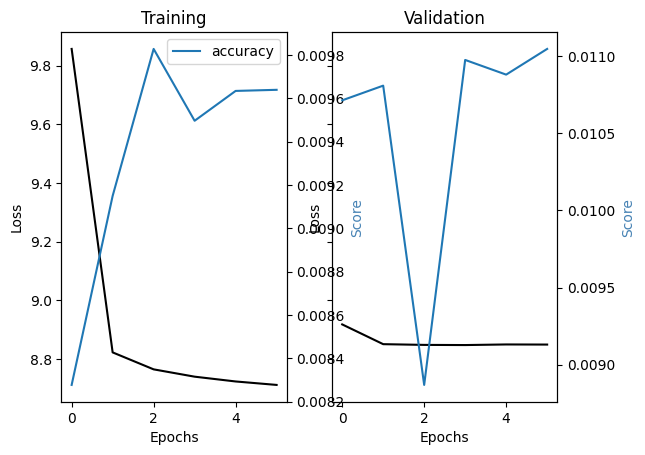

In [69]:
## train
training = model.fit(x=[X_train, y_train[:,:-1]], 
                     y=y_train.reshape(y_train.shape[0], 
                                       y_train.shape[1], 
                                       1)[:,1:],
                     batch_size=128, 
                     epochs=100, 
                     shuffle=True, 
                     verbose=1, 
                     validation_split=0.3,
                     callbacks=[callbacks.EarlyStopping(
                                monitor='val_loss', 
                                mode='min', verbose=1, patience=2)]
                      )
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [70]:
# Prediction Encoder
encoder_model = models.Model(inputs=x_in, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
encoder_model.summary()

Model: "Prediction_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 15)]              0         
                                                                 
 x_emb (Embedding)           (None, 15, 300)           39429000  
                                                                 
 x_lstm (LSTM)               [(None, 15, 250),         551000    
                              (None, 250),                       
                              (None, 250)]                       
                                                                 
Total params: 39,980,000
Trainable params: 39,980,000
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Prediction Decoder
## double the lstm units if you used bidirectional lstm
lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
## states of the previous time step
encoder_out = layers.Input(shape=(X_train.shape[1], lstm_units))
state_h, state_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
## decoder embeddings
y_emb2 = layer_y_emb(y_in)
## lstm to predict the next word
y_out2, state_h2, state_c2 = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])
## softmax to generate probability distribution over the vocabulary
probs = layer_dense(y_out2)
## compile
decoder_model = models.Model(inputs=[y_in, encoder_out, state_h, state_c], outputs=[probs, state_h2, state_c2], name="Prediction_Decoder")
decoder_model.summary()

Model: "Prediction_Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 y_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 y_emb (Embedding)              (None, None, 300)    11353200    ['y_in[0][0]']                   
                                                                                                  
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 250)]        0           []                               
                                                                                 

In [ ]:
# Predict
max_seq_lenght = X_test.shape[1]
predicted = []
predicted_text = ' '
for x in X_test:
   x = x.reshape(1,-1)
   ## encode X
   encoder_out, state_h, state_c = encoder_model.predict(x)
   ## prepare loop
   y_in = np.array([tokenizer.word_index[special_tokens[0]]])
   predicted_text = ""
   stop = False
   while not stop:
        ## predict dictionary probability distribution
        probs, new_state_h, new_state_c = decoder_model.predict(
                          [y_in, encoder_out, state_h, state_c])
        
        ## get predicted word
        voc_idx = np.argmax(probs[0,-1,:])
        pred_word = tokenizer.index_word[voc_idx]
        
        ## check stop
        if (pred_word != special_tokens[1]) and (len(predicted_text.split()) < max_seq_lenght):
            predicted_text = predicted_text +" "+ pred_word
        else:
            stop = True
        
        ## next
        y_in = np.array([voc_idx])
        state_h, state_c = new_state_h, new_state_c
   predicted_text = predicted_text.replace(
                    special_tokens[0],"").strip()
   predicted.append(predicted_text)